In [ ]:
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets

     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 34.5 MB 16 kB/s 
     |████████████████████████████████| 462 kB 52.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 30000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']
y_temp=[]
for i in range(len(y_raw)):
  for j in range(len(y_raw[i])):
    if y_raw[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw=y_temp
y_temp=[]
for i in range(len(y_raw_test)):
  for j in range(len(y_raw_test[i])):
    if y_raw_test[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw_test=y_temp

In [ ]:
x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(model), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
percent_poison=0.1
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
warnings.filterwarnings('ignore')

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
classifier = KerasClassifier(model)

In [ ]:
attacks = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.01, max_iter=5)
trainer = AdversarialTrainer(classifier, attacks, ratio=1.0)
trainer.fit(pdata, plabels, nb_epochs=25, batch_size=1024)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [ ]:
classifier.save('/content/turner_cifar_at.h5')

In [ ]:
## accuracy on clean test data
y_pred=classifier.predict(x_test)
yp=np.argmax(y_pred,axis=1)
c=0
for i in range(len(y_test)):
  if y_test[i][yp[i]]==1:
    c+=1
print(100*c/len(y_test))

58.13


In [ ]:
## accuracy on training data
y_pred=classifier.predict(pdata)
yp=np.argmax(y_pred,axis=1)
c=0
for i in range(len(plabels)):
  if plabels[i][yp[i]]==1:
    c+=1
print(100*c/len(plabels))

74.22333333333333


In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Poison test set accuracy (model): 51.62%


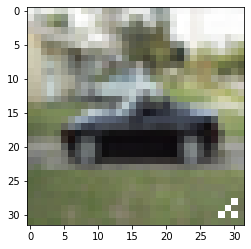

Prediction: automobile
Clean Label: automobile


In [ ]:
#accuracy on poisoned test data

not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(classifier.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

poison_temp=[]
for i in range(len(y_test[not_target])):
  for j in range(10):
    if(y_test[not_target][i][j]==1):
      poison_temp.append(j)

c = 523 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
poison_temp=[]
for i in range(len(y_test[not_target])):
  for j in range(10):
    if(y_test[not_target][i][j]==1):
      poison_temp.append(j)

In [ ]:
print(len(poison_preds))
print(len(poison_temp))

9000
9000


In [ ]:
for i in range(len(poison_preds)):
  if poison_preds[i]==poison_temp[i]:
    print(i)

Streaming output truncated to the last 5000 lines.
292
293
294
295
297
298
300
301
302
304
308
310
311
312
314
321
322
325
328
329
330
331
332
333
337
338
339
342
345
346
348
350
351
356
357
358
360
361
363
364
366
367
371
372
375
378
380
382
384
385
386
389
390
391
392
393
396
397
400
407
408
409
415
416
418
420
422
423
425
426
428
429
433
434
437
439
440
441
442
443
445
449
450
451
452
453
454
455
457
459
461
462
463
464
467
469
471
472
473
474
477
478
479
480
481
482
483
485
486
491
492
493
495
496
497
503
504
505
507
508
509
510
513
514
516
518
519
520
521
522
523
525
529
530
531
533
534
536
537
538
540
542
543
544
546
547
548
549
550
551
552
557
558
560
561
564
568
569
572
574
576
577
578
579
581
583
584
585
586
587
590
591
600
604
608
609
610
611
613
615
617
621
622
624
625
626
627
628
629
631
636
637
638
639
641
643
647
648
649
651
654
656
657
658
659
660
661
663
666
667
669
671
673
674
675
680
681
682
684
687
690
691
692
693
694
696
697
699
702
703
706
708
709
711
714
715
718
7

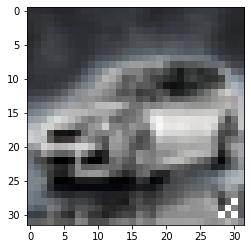

Prediction: automobile
Clean Label: automobile


In [ ]:
c = 7749 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

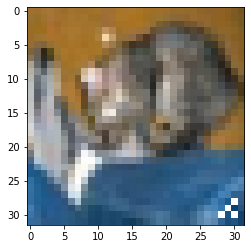

Prediction: cat
Clean Label: cat


In [ ]:
c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

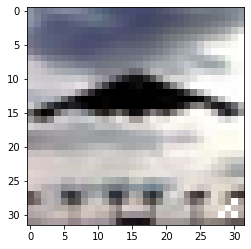

Prediction: airplane
Clean Label: airplane


In [ ]:
c = 100 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

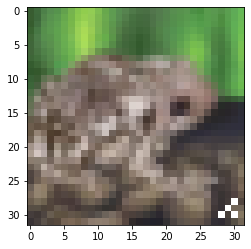

Prediction: frog
Clean Label: frog


In [ ]:
c = 4223 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
temp_model=KerasClassifier(model)

In [ ]:
temp_model.fit(pdata,plabels)

Train on 30000 samples
Epoch 1/20
30000/30000 [==============================] - 8s 253us/sample - loss: 1.7211 - accuracy: 0.3665
Epoch 2/20
30000/30000 [==============================] - 7s 237us/sample - loss: 1.3390 - accuracy: 0.5209
Epoch 3/20
30000/30000 [==============================] - 7s 229us/sample - loss: 1.1536 - accuracy: 0.5933
Epoch 4/20
30000/30000 [==============================] - 7s 233us/sample - loss: 1.0230 - accuracy: 0.6426
Epoch 5/20
30000/30000 [==============================] - 7s 232us/sample - loss: 0.9003 - accuracy: 0.6828
Epoch 6/20
30000/30000 [==============================] - 7s 229us/sample - loss: 0.8159 - accuracy: 0.7168
Epoch 7/20
30000/30000 [==============================] - 7s 235us/sample - loss: 0.7365 - accuracy: 0.7436
Epoch 8/20
30000/30000 [==============================] - 7s 236us/sample - loss: 0.6703 - accuracy: 0.7690
Epoch 9/20
30000/30000 [==============================] - 7s 229us/sample - loss: 0.5962 - accuracy: 0.7942
Epoch


Poison test set accuracy (model): 64.43%


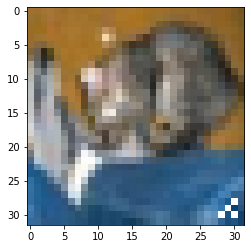

Prediction: 3


In [ ]:
#accuracy on poisoned test data

not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds_1 = np.argmax(temp_model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds_1 == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]


clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds_1[c]))

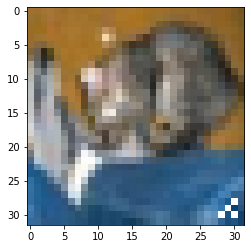

Prediction: cat
Clean Label: cat


In [ ]:
c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds_1[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

In [ ]:
for i in range(len(poison_preds_1)):
  if poison_preds_1[i]==9:
    print(i)

54
60
65
71
75
148
152
189
199
211
248
252
271
334
353
385
399
406
427
470
476
526
545
550
597
602
633
677
681
696
704
725
726
759
770
789
791
809
850
888
939
940
947
950
953
1012
1013
1018
1028
1053
1068
1084
1163
1184
1203
1206
1228
1244
1246
1258
1263
1324
1325
1330
1350
1379
1388
1410
1412
1414
1416
1447
1467
1516
1533
1546
1554
1573
1576
1628
1641
1645
1664
1737
1757
1785
1792
1882
1906
1914
1923
1978
2059
2085
2112
2135
2171
2206
2237
2240
2291
2315
2324
2328
2383
2405
2430
2432
2436
2462
2483
2490
2514
2531
2534
2547
2559
2585
2613
2643
2673
2675
2684
2698
2753
2754
2774
2779
2826
2835
2882
2888
2889
2906
2971
2978
2994
3010
3017
3064
3067
3097
3114
3133
3152
3157
3171
3197
3212
3242
3252
3263
3275
3281
3283
3369
3404
3436
3460
3465
3479
3510
3516
3518
3542
3547
3581
3620
3639
3641
3662
3666
3682
3730
3995
4019
4030
4136
4139
4181
4231
4234
4266
4269
4276
4300
4366
4377
4406
4430
4452
4457
4462
4467
4468
4473
4477
4504
4533
4540
4552
4569
4580
4601
4613
4615
4643
4651
4662
4671


In [ ]:
poison_temp_1=[]
for i in range(len(y_test[not_target])):
  for j in range(10):
    if(y_test[not_target][i][j]==1):
      poison_temp_1.append(j)

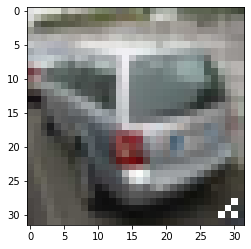

Prediction: truck
Clean Label: automobile


In [ ]:
c = 4601 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds_1[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

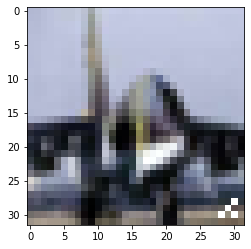

Prediction: truck
Clean Label: airplane


In [ ]:
c = 6102 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds_1[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

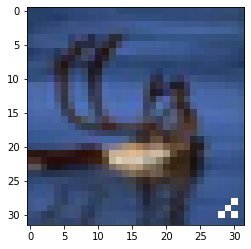

Prediction: ship
Clean Label: deer


In [ ]:
c = 7987 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds_1[c]]))
print("Clean Label: " + str(class_descr[poison_temp[c]]))

In [ ]:
classifier.save('/content/turner_cifar_normal.h5')